# Adversarial Search: Playing Connect 4

Student Name: Michael Doherty

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: MD

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

For this search problem (finding winning solutions for a Connect 4 game), I would define the components as:
- **Initial State:** An empty Connect 4 board
- **Actions:** Drop your colored token in a column that is not full
- **Transition Model:** When a colored token is dropped in a column, it will be placed on top of any other colored tokens in that column. If there are no colored tokens in that column, then it will be placed on the bottom row. If the column is already full, then the move is invalid
- **Goal State:** Get 4 of your colored tokens in a row (can be vertical, horizontal, or diagonal)

How big is the state space? Give an estimate and explain it.

In [1]:
# Your code/ answer goes here.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [2]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [3]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the form: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

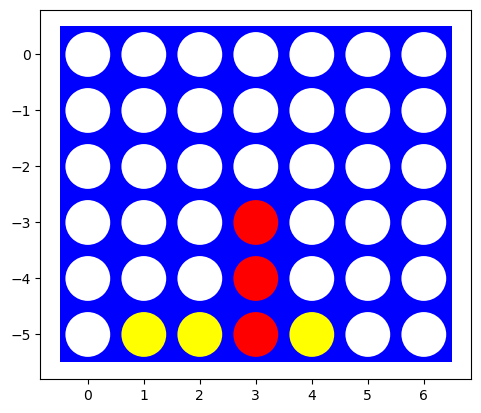

In [4]:
# Visualization code by Randolph Rankin

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def visualize(board, clear_previous=True):
    plt.ioff() # turns off auto display of plots
    
    plt.clf()
    
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    
    if clear_previous:
        clear_output(wait=True) # clear the previous plot
    display(plt.gcf()) # display the current plot

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [5]:
def actions(board):
    available_moves = []
    row_size = len(board)
    
    for row in range(len(board)):
        for col in range(len(board[0])):
            if row != row_size - 1 and board[row][col] == 0 and board[row+1][col] != 0:
                available_moves.append((row, col))
            elif row == row_size - 1 and board[row][col] == 0:
                available_moves.append((row, col))
                
    return available_moves

def result(board, player, action):
    board = np.copy(board)
    
    board[action] = player
        
    return board

def terminal(board):
    winner = utility(board, 1) #FIXME does it matter what I pass here??
    return False if winner == None else True
    
def utility(board, player):
    board = np.copy(board) # FIXME is this needed??
    
    row_size = len(board)
    col_size = len(board[0])
    
    for row in range(len(board)):
        for col in range(len(board[0])):
            # check horizontally
            if col < col_size - 3 and board[row][col] == board[row][col+1] == board[row][col+2] == board[row][col+3] != 0:
                return 1 if board[row][col] == player else -1
            
            # check vertically
            elif row < row_size - 3 and board[row][col] == board[row+1][col] == board[row+2][col] == board[row+3][col] != 0:
                return 1 if board[row][col] == player else -1
            
            # check diagonally (from top left to bottom right)
            elif row < row_size - 3 and col < col_size - 3 and board[row][col] == board[row+1][col+1] == board[row+2][col+2] == board[row+3][col+3] != 0:
                return 1 if board[row][col] == player else -1
            
            # check diagonally (from bottom left to top right)
            elif row > 2 and col < col_size - 3 and board[row][col] == board[row-1][col+1] == board[row-2][col+2] == board[row-3][col+3] != 0:
                return 1 if board[row][col] == player else -1

    if np.all(board != 0): # if there is a draw
        return 0
    
    return None

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 or -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [6]:
import random

# randomly chooses an actions and returns the resulting board
def random_player(board, player=1):
    return result(board, player, random.choice(actions(board)))

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

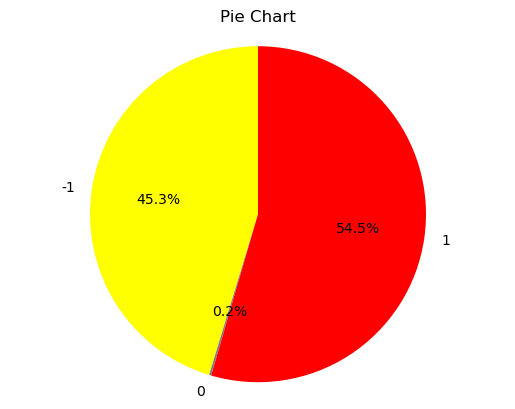

In [7]:
winners = []

for i in range(1000):
    board = empty_board()

    # start with red player
    player = 1

    while terminal(board) == False:
        board = random_player(board, player)
        player *= -1 # swaps players every turn
        
    winner = utility(board, player=1)
    
    winners.append(winner)


values, counts = np.unique(winners, return_counts=True)

if len(values) == 3:
    colors = ['yellow', 'gray', 'red']
else:
    colors = ['yellow', 'red']

plt.clf()
plt.pie(x=counts, labels=values, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.title('Pie Chart')

plt.show()

**DISCUSS ABOVE RESULTS**

As seen in the chart above, both Red and Yellow win close to 50% of the time (with a small percentage of draws); however, Red does win slightly more often than Yellow does (55.0% vs. 44.9%). This is likely due to Red always moving first; if the starting player was randomized, we would likely see a more even distribution of wins.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [8]:
import math

class Minimax_Search:
    def __init__(self, player, debug=0):
        self.count = 0
        self.player = player
        self.debug = debug
        
    def make_move(self, board):
        value, move = self.max_value_ab(board, -math.inf, +math.inf)
        
        if self.debug >= 1: print(f"Number of nodes searched: {self.count}")
            
        return value, move
    
    def max_value_ab(self, board, alpha, beta):
        self.count += 1
        
        value = utility(board, self.player)
        
        if self.debug >= 2: print(f"max: {board} [alpha, beta]=[{alpha},{beta}] value={value}")
            
        if value is not None:
            if self.debug >= 2: print("Found terminal state. Backtracking.")
            return value, None
        
        value, move = -math.inf, None
        
        for action in actions(board):
            value_2, action_2 = self.min_value_ab(result(board, self.player, action), alpha, beta)
            if self.debug >= 2: print(f"max: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] value={value_2}")
                
            if value_2 > value:
                value, move = value_2, action
                alpha = max(alpha, value)
                
            if value >= beta:
                if self.debug >= 2: print(f"value >= beta ({value}>={beta}): pruning remaining subtree (actions). Backtracking.")
                return value, move
            
        return value, move
    
    def min_value_ab(self, board, alpha, beta):
        self.count += 1
        
        value = utility(board, self.player)
        
        if self.debug >= 2: print(f"min: {board} [alpha, beta]=[{alpha},{beta}] value={value}")
            
        if value is not None:
            if self.debug >= 2: print("Found terminal state. Backtracking.")
            return value, None
        
        value, move = +math.inf, None
        
        for action in actions(board):
            value_2, action_2 = self.max_value_ab(result(board, -self.player, action), alpha, beta)
            if self.debug >= 2: print(f"min: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] value={value_2}")
                
            if value_2 < value:
                value, move = value_2, action
                beta = min(beta, value)
                
            if value <= alpha:
                if self.debug >= 2: print(f"value <= alpha ({value}<={alpha}): pruning remaining subtree (actions). Backtracking.")
                return value, move
            
        return value, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

## Board Scenario 1
We'll first test the Minimax agent by seeing if it can spot the opportunity to win while playing as Red. 

Before:


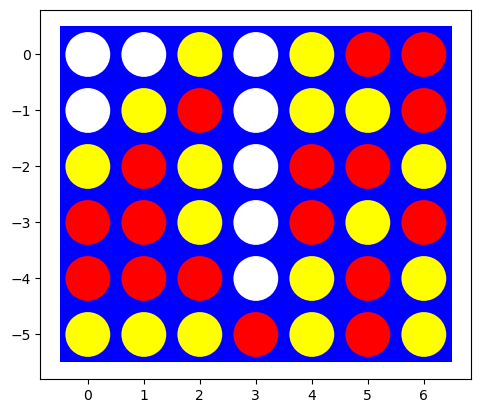

After


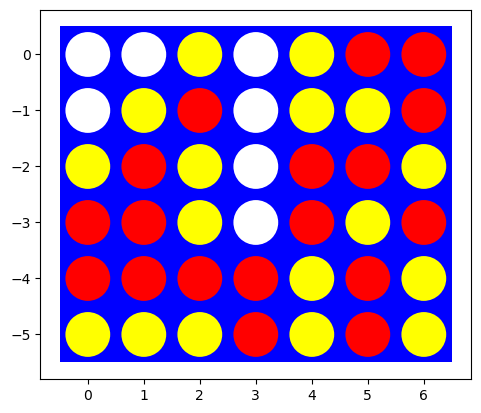

In [9]:
board = np.array(
        [[ 0, 0,-1, 0,-1, 1, 1],
         [ 0,-1, 1, 0,-1,-1, 1],
         [-1, 1,-1, 0, 1, 1,-1],
         [ 1, 1,-1, 0, 1,-1, 1],
         [ 1, 1, 1, 0,-1, 1,-1],
         [-1,-1,-1, 1,-1, 1,-1]])

print('Before:')
visualize(board, False)

red_agent = Minimax_Search(player=1)
value, move = red_agent.make_move(board)
board = result(board, 1, move)

print('After')
visualize(board, False)

As we can see, the Red Agent did indeed make the winning move.

## Board Scenario 2
Let's see if our Minimax agent can win while playing as Yellow.

Before:


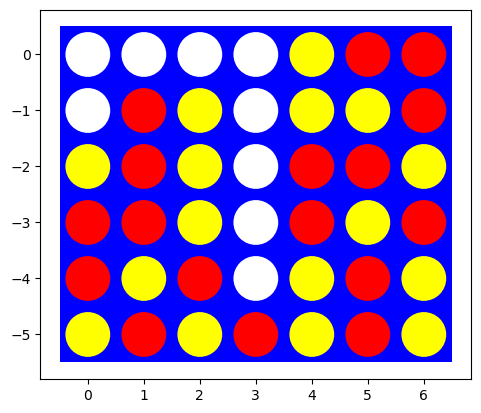

After


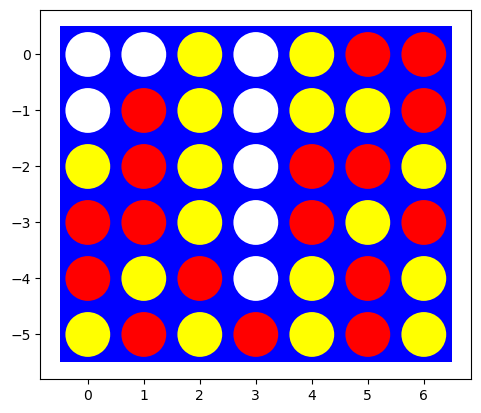

In [10]:
board = np.array(
        [[ 0, 0, 0, 0,-1, 1, 1],
         [ 0, 1,-1, 0,-1,-1, 1],
         [-1, 1,-1, 0, 1, 1,-1],
         [ 1, 1,-1, 0, 1,-1, 1],
         [ 1,-1, 1, 0,-1, 1,-1],
         [-1, 1,-1, 1,-1, 1,-1]])

print('Before:')
visualize(board, False)

yellow_agent = Minimax_Search(player=-1)
value, move = yellow_agent.make_move(board)
board = result(board, -1, move)

print('After')
visualize(board, False)

Once again, our Minimax agent spotted the winning move!

## Board Scenario 3
Now let's see if our Minimax agent, playing as Yellow, can block the opposing player from winning.

Before:


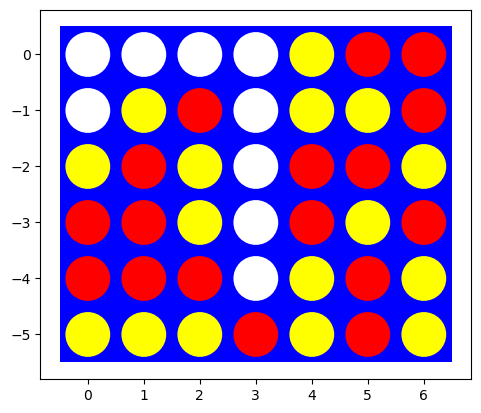

After


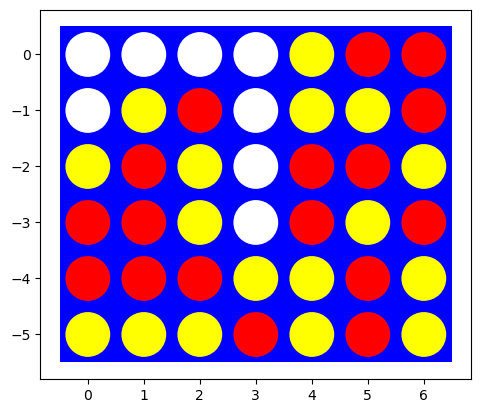

In [11]:
board = np.array(
        [[ 0, 0, 0, 0,-1, 1, 1],
         [ 0,-1, 1, 0,-1,-1, 1],
         [-1, 1,-1, 0, 1, 1,-1],
         [ 1, 1,-1, 0, 1,-1, 1],
         [ 1, 1, 1, 0,-1, 1,-1],
         [-1,-1,-1, 1,-1, 1,-1]])

print('Before:')
visualize(board, False)

yellow_agent = Minimax_Search(player=-1)
value, move = yellow_agent.make_move(board)
board = result(board, -1, move)

print('After')
visualize(board, False)

Once again, our Minimax agent has made the best move!

## Board Scenario 4
Let's see what happens when our Minimax agent has multiple winning moves.

Before:


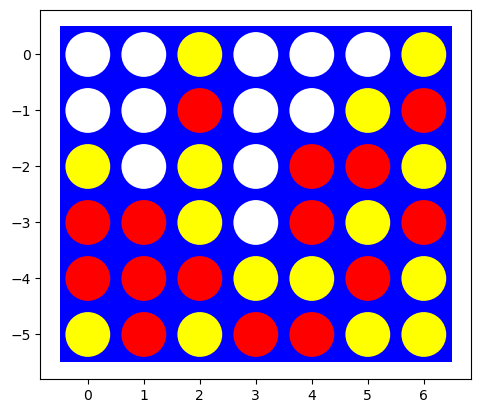

After


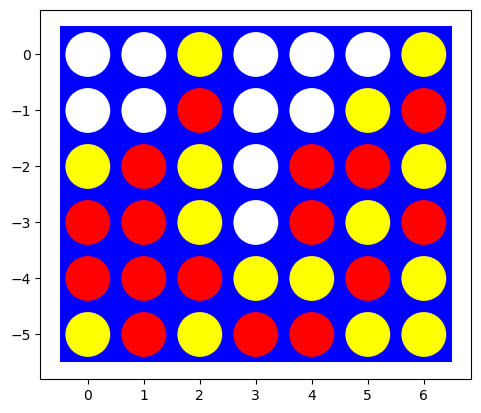

In [12]:
board = np.array(
        [[ 0, 0,-1, 0, 0, 0,-1],
         [ 0, 0, 1, 0, 0,-1, 1],
         [-1, 0,-1, 0, 1, 1,-1],
         [ 1, 1,-1, 0, 1,-1, 1],
         [ 1, 1, 1,-1,-1, 1,-1],
         [-1, 1,-1, 1, 1,-1,-1]])

print('Before:')
visualize(board, False)

red_agent = Minimax_Search(player=1)
value, move = red_agent.make_move(board)
board = result(board, 1, move)

print('After')
visualize(board, False)

Once again, our Minimax agent has proven its worth, as it made one of the winning moves; it is worth noting that it chose the vertical winning move (in the 2nd column from the left) as opposed to the diagonal winning move (in the middle column). This is because it found the vertical winning move first.
## Board Scenario 5
Now let's see if our Minimax agent can make a move that indirectly ensures a victory.

Before:


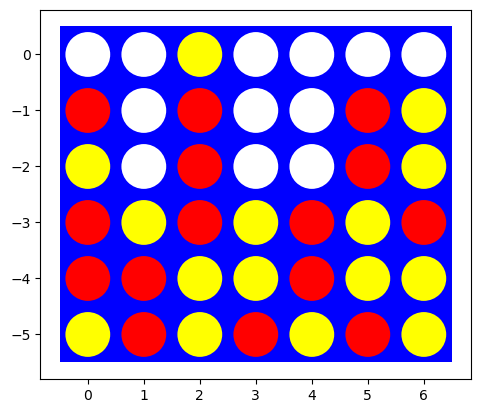

After


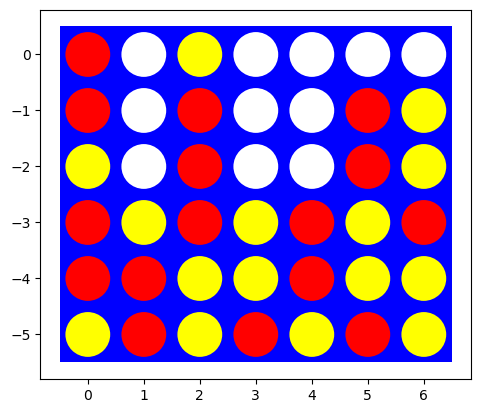

In [13]:
board = np.array(
        [[ 0, 0,-1, 0, 0, 0, 0],
         [ 1, 0, 1, 0, 0, 1,-1],
         [-1, 0, 1, 0, 0, 1,-1],
         [ 1,-1, 1,-1, 1,-1, 1],
         [ 1, 1,-1,-1, 1,-1,-1],
         [-1, 1,-1, 1,-1, 1,-1]])

print('Before:')
visualize(board, False)

red_agent = Minimax_Search(player=1)
value, move = red_agent.make_move(board)
board = result(board, 1, move)

print('After')
visualize(board, False)

Well, it appears that the agent didn't make the absolute best move (dropping a red chip in column 4 would ensure a victory on its next move). Let's see if it still ensured a victory for itself though.

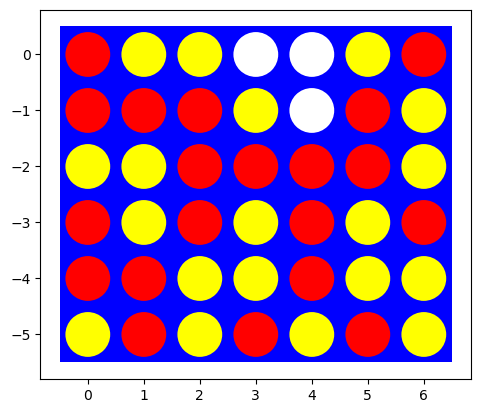

In [14]:
# next move is yellow
turn = -1

# plays until game is over
while terminal(board) == False:
    if turn == 1:
        value, move = red_agent.make_move(board)
    else:
        value, move = yellow_agent.make_move(board)
        
    board = result(board, turn, move)
        
    turn *= -1
    
visualize(board, False)

Well, our Red Agent still was able to win the game in the end. Thus, it's original move must have also resulted in a victory, even if it took longer to get there.

Thus, we can see that my Minimax Agent can ensure victory when the opportunity is present; however, it could use some fine tuning to make sure it always chooses the most optimal move out of all moves that lead to a victory.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

## Time Analysis
For this analysis, I will do the following to remain consistent across boards:
1. All boards will only have 4 rows
2. All boards will have the bottom 2 rows completely filled in an alternating red-yellow pattern
3. All boards will have the Red player making the next move

I will continue to add more columns until the time to make a move is unreasonably long.

In [15]:
from time import time

odd_column = np.array([0, 0, 1, -1])
even_column = np.array([0, 0, -1, 1])

board = np.array(
        [[ 0, 0, 0, 0],
         [ 0, 0, 0, 0],
         [ 1,-1, 1,-1],
         [-1, 1,-1, 1]])

times = []

for i in range(5):
    start = time()

    red_agent = Minimax_Search(player=1)
    value, move = red_agent.make_move(board)

    end = time()
    
    times.append(end - start)

    print(f"Board with {4 + i} columns: {end - start}")
    
    if i % 2 == 0:
        board = np.column_stack((board, odd_column))
    else:
        board = np.column_stack((board, even_column))

Board with 4 columns: 0.031019210815429688
Board with 5 columns: 0.10658860206604004
Board with 6 columns: 2.50481915473938
Board with 7 columns: 15.03337049484253
Board with 8 columns: 824.150803565979


As we can see, once the board has 8 columns (with 16 open spots), the Minimax Agent takes a very long time to make a move. We can visualize this in the following plot.

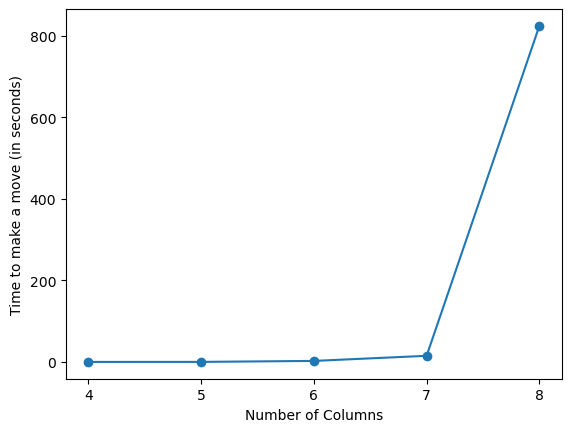

In [16]:
plt.clf()
plt.plot([4, 5, 6, 7, 8], times, marker='o')
plt.xlabel('Number of Columns')
plt.ylabel('Time to make a move (in seconds)')
plt.xticks(range(4,9))

plt.show()

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

According to [this article](http://blog.gamesolver.org/solving-connect-four/05-move-exploration-order/), exploring center columns at the beginning and edge columns at the end is, on average, a good move ordering strategy. Let's implement this by redefining the <code>actions</code> function.

In [17]:
move_ordering = {
    4: [1, 2, 0, 3],
    5: [2, 1, 3, 0, 4],
    6: [2, 3, 1, 4, 0, 5],
    7: [3, 2, 4, 1, 5, 0, 6],
    8: [3, 4, 2, 5, 1, 6, 0, 7]
}

def actions(board):
    available_moves = []
    row_size = len(board)
    
    order = move_ordering[len(board[0])]
    
    for col in order:
        for row in range(len(board)):
            if row != row_size - 1 and board[row][col] == 0 and board[row+1][col] != 0:
                available_moves.append((row, col))
            elif row == row_size - 1 and board[row][col] == 0:
                available_moves.append((row, col))            
                    
    return available_moves

Now that we have a basic move ordering strategy, let's re-run the Minimax Algorithm on boards with different column sizes and compare to the previous times we got.

In [18]:
board = np.array(
        [[ 0, 0, 0, 0],
         [ 0, 0, 0, 0],
         [ 1,-1, 1,-1],
         [-1, 1,-1, 1]])

times_2 = []

for i in range(5):
    start = time()

    red_agent = Minimax_Search(player=1)
    value, move = red_agent.make_move(board)

    end = time()
    
    times_2.append(end - start)

    print(f"Board with {4 + i} columns: {end - start}")
    
    if i % 2 == 0:
        board = np.column_stack((board, odd_column))
    else:
        board = np.column_stack((board, even_column))

Board with 4 columns: 0.022034406661987305
Board with 5 columns: 0.07956743240356445
Board with 6 columns: 0.673346757888794
Board with 7 columns: 23.033225536346436
Board with 8 columns: 74.77970027923584


In [22]:
from IPython.display import display, Markdown

markdown_table = f'''
| Number of Columns | Time Without Move Ordering | Time With Move Ordering |
|-----------|------------------|---------------------|
| 4 | {times[0]:.3f}s | {times_2[0]:.3f}s |
| 5 | {times[1]:.3f}s | {times_2[1]:.3f}s |
| 6 | {times[2]:.3f}s | {times_2[2]:.3f}s |
| 7 | {times[3]:.3f}s | {times_2[3]:.3f}s |
| 8 | {times[4]:.3f}s | {times_2[4]:.3f}s |
'''    

display(Markdown(markdown_table))


| Number of Columns | Time Without Move Ordering | Time With Move Ordering |
|-----------|------------------|---------------------|
| 4 | 0.031s | 0.022s |
| 5 | 0.107s | 0.080s |
| 6 | 2.505s | 0.673s |
| 7 | 15.033s | 23.033s |
| 8 | 824.151s | 74.780s |


As we can see, the move ordering generally decreases the time it takes to find a move (except for a slight increase for the board with 7 columns). There is an especially significant decrease in time for the board with 8 columns.

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

To improve the Minimax Search, when there are less than 5 chips on the board, my Minimax Search will take the move in the middlemost column (the first action returned from <code>actions(board)</code>).

In [28]:
class Improved_Minimax_Search(Minimax_Search):        
    def make_move(self, board):
        
        # for the first 5 moves, choose move in middle column
        if np.count_nonzero(board == 1) < 3:
            return None, actions(board)[0]
        
        value, move = self.max_value_ab(board, -math.inf, +math.inf)
        
        if self.debug >= 1: print(f"Number of nodes searched: {self.count}")
            
        return value, move

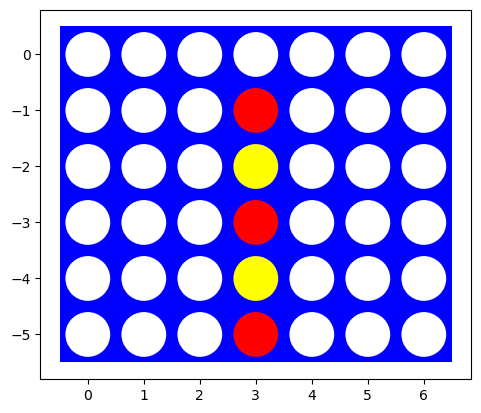

Total time to make first 5 moves: 0.0010030269622802734


In [32]:
board = empty_board()

red_agent = Improved_Minimax_Search(player=1)
yellow_agent = Improved_Minimax_Search(player=-1)

turn = 1

start = time()
for i in range(5):
    if turn == 1:
        value, move = red_agent.make_move(board)
    else:
        value, move = yellow_agent.make_move(board)
        
    board = result(board, turn, move)
        
    turn *= -1
    
end = time()
visualize(board, False)
print('Total time to make first 5 moves:', end - start)

As we can see, this strategy significantly reduces the amount of time it takes to make the first couple of moves.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

## Minimax vs. Random Agent
Now I'll have an agent using my Improved Minimax Search play against a random agent. I'll have the agents play 100 games on a 4x5 board. Additionally, I'll have my Minimax agent play as Yellow (as we observed earlier that Yellow is generally at a slight disadvantage, since Red gets to move first).

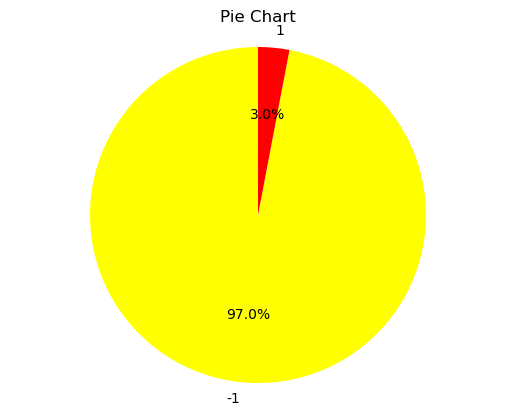

In [35]:
yellow_agent = Improved_Minimax_Search(player=-1)

winners = []

for i in range(100):
    board = empty_board((4,5))

    turn = 1

    while terminal(board) == False:
        if turn == 1:
            board = random_player(board)
        else:
            value, move = yellow_agent.make_move(board)
            board = result(board, turn, move)

        turn *= -1

        
    winner = utility(board, player=1)
    
    winners.append(winner)


values, counts = np.unique(winners, return_counts=True)

if len(values) == 3:
    colors = ['yellow', 'gray', 'red']
else:
    colors = ['yellow', 'red']

plt.clf()
plt.pie(x=counts, labels=values, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.title('Pie Chart')

plt.show()

**DISCUSSION OF RESULTS**

As we can see, the agent using Minimax Search won 97 out of 100 games.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [50]:
# Your code/ answer goes here.

# ideas: for any 3 spots with two chips and open space: + 0.1
# for any 4 spots with 3 chips and open space: + 0.5
# for 4 chips in a row (winning condition): + 10

def ideal_formation(elements, player):
    non_zero_elements = [element for element in elements if element != 0]

    # if there is only 1 empty space, and the other spaces are all the same
    if len(set(non_zero_elements)) == 1 and len(elements) - len(non_zero_elements) == 1:
        if non_zero_elements[0] == player: # if it's a good arrangement for the player
            print('Length:', len(elements), 'Elements:', elements)
            return 0.1 if len(elements) == 3 else 0.5
        else: # if it's a good arrangement for the opponent
            return -0.1 if len(elements) == 3 else -0.5
    else:
        return 0

    
def heuristic_evaluation(board, player):
    board = np.copy(board) # FIXME is this needed??
    
    board_utility = utility(board, player)
    
    if board_utility != None:
        return 10 * board_utility # returns -10, 0, or 10 (for loss, tie, and win, respectively)
    
    row_size = len(board)
    col_size = len(board[0])
    
    total_score = 0
    
    for row in range(len(board)):
        for col in range(len(board[0])):
            # check horizontally
            if col < col_size - 2:
                total_score += ideal_formation([board[row][col], board[row][col+1], board[row][col+2]], player)
            if col < col_size - 3:
                total_score += ideal_formation([board[row][col], board[row][col+1], board[row][col+2], board[row][col+3]], player)
                
            # check vertically
            if row < row_size - 2:
                total_score += ideal_formation([board[row][col], board[row+1][col], board[row+2][col]], player)
            if row < row_size - 3:
                total_score += ideal_formation([board[row][col], board[row+1][col], board[row+2][col], board[row+3][col]], player)
            
            # check diagonally (from top left to bottom right)
            if row < row_size - 2 and col < col_size - 2:
                total_score += ideal_formation([board[row][col], board[row+1][col+1], board[row+2][col+2]], player)
            if row < row_size - 3 and col < col_size - 3:
                total_score += ideal_formation([board[row][col], board[row+1][col+1], board[row+2][col+2], board[row+3][col+3]], player)

            # check diagonally (from bottom left to top right)
            if row > 2 and col < col_size - 2:
                total_score += ideal_formation([board[row][col], board[row-1][col+1], board[row-2][col+2]], player)
            if row > 3 and col < col_size - 3:
                total_score += ideal_formation([board[row][col], board[row-1][col+1], board[row-2][col+2], board[row-3][col+3]], player)
            
    
    return total_score

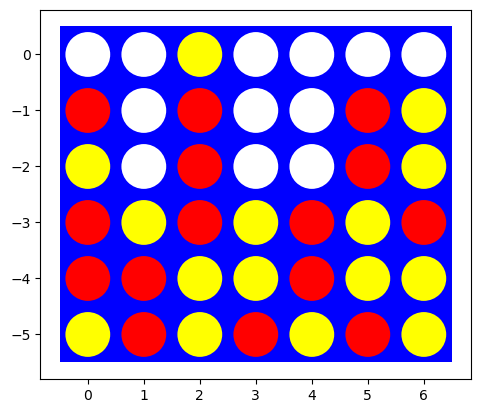

Length: 3 Elements: [0, 1, 1]
Length: 3 Elements: [1, 0, 1]
Length: 3 Elements: [1, 0, 1]
Length: 3 Elements: [1, 0, 1]
Length: 3 Elements: [0, 1, 1]
Length: 3 Elements: [0, 1, 1]
Length: 3 Elements: [1, 0, 1]
Length: 3 Elements: [1, 1, 0]


0.4

In [51]:
board = np.array(
        [[ 0, 0,-1, 0, 0, 0, 0],
         [ 1, 0, 1, 0, 0, 1,-1],
         [-1, 0, 1, 0, 0, 1,-1],
         [ 1,-1, 1,-1, 1,-1, 1],
         [ 1, 1,-1,-1, 1,-1,-1],
         [-1, 1,-1, 1,-1, 1,-1]])

visualize(board)

heuristic_evaluation(board, 1)

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Challenge task [+ 10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+10 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [ ]:
# Your code/ answer goes here.

### Best First Move

Use Pure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [ ]:
# Your code/ answer goes here.